In [1]:
from itertools import combinations, permutations, product
from pathlib import Path

import duckdb
import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import polars as pl
import pygwalker as pyg
import seaborn as sns
import srsly
from matplotlib import ticker
from tqdm.auto import tqdm

In [2]:
pl.Config.set_fmt_str_lengths(100)
con = duckdb.connect()

In [4]:
hparams = []

for p in tqdm(list(Path("../outputs/multirun/").rglob("*/*/*/tb_logs.parquet"))):
    meta = srsly.read_yaml(p.parent / "hparams.yaml")
    hparams.append(
        dict(
            strategy=p.parents[0].name.split("_")[0],
            filename=str(p),
            data_seed=meta["data"]["seed"],
            model_seed=meta["model"]["seed"],
            seed=f'{meta["data"]["seed"]}-{meta["model"]["seed"]}',
            group=p.parents[2].name,
            num_anchors=meta["strategy"].get("num_anchors", None),
            subpool_size=meta["strategy"].get("subpool_size", None),
            subpool_sampling_strategy=meta["strategy"].get("subpool_sampling_strategy", None),
            num_neighbours=meta["strategy"].get("num_neighbours", None),
            anchor_strategy=meta["strategy"].get("anchor_strategy", None),
            positive_budget=meta["active_data"].get("positive_budget", None),
            retriever=meta["index_metric"],
            dataset=meta["dataset"]["short_name"],
        )
    )

hparams_df = pd.DataFrame(hparams)

  0%|          | 0/597 [00:00<?, ?it/s]

In [5]:
count_query = """
SELECT tag, count(tag)
FROM read_parquet('../outputs/multirun/*/*/*/tb_logs.parquet', filename=True)
GROUP BY tag
"""
metrics = con.execute(count_query).df()

In [6]:
metrics.query("tag.str.startswith('summary')")

,tag,count(tag)
4,summary/count_class_0,21492
5,summary/count_class_1,21492
6,summary/cumulative_count_class_0,22089
7,summary/cumulative_count_class_1,22089
8,summary/cumulative_minority_ratio,22089
9,summary/labelled_size,22089
10,summary/minority_ratio,21492
11,summary/num_anchors,17172
12,summary/pool_size,22089
13,summary/subpool_size,21492


In [7]:
count_query = """
SELECT *
FROM read_parquet('../outputs/multirun/*/*/*/tb_logs.parquet', filename=True)
WHERE tag IN (
    'test/f1_class1_vs_budget',
    'test/loss',
    'summary/unique_ids_retrieved',
    'summary/count_class_1',
)
"""

all_df = con.execute(count_query).df()

In [8]:
df = pd.merge(all_df, hparams_df, on="filename", how="left")
assert df["group"].isna().sum() == 0

In [9]:
df = df.assign(
    strategy_name=lambda _df: _df["strategy"].str.split("-", expand=True).get(0)
)

In [10]:
df["strategy_name"].value_counts()

strategy_name
anchoral        52470
tyrogue          4400
seals            4400
randomsubset     4400
Name: count, dtype: int64

In [11]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.style.use("bmh")
sns.set_context("paper")
plt.ion()
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]

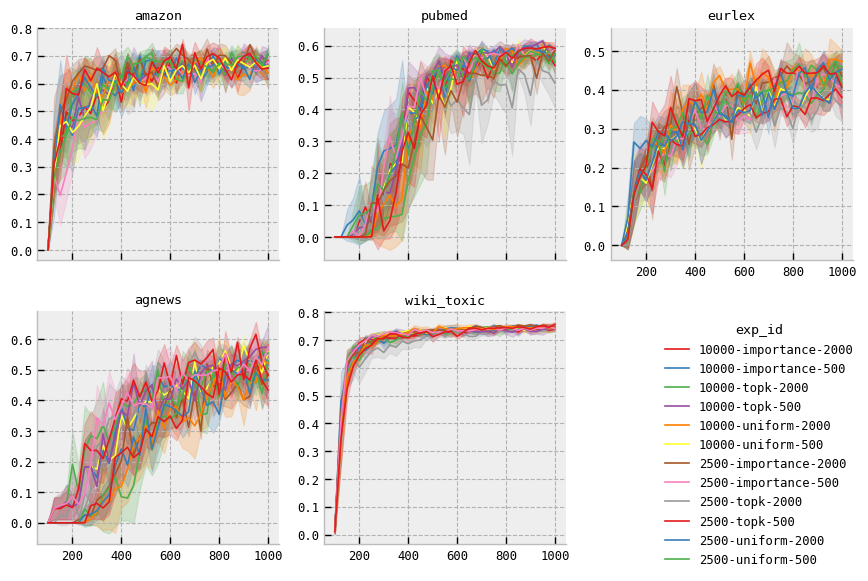

In [74]:
plot_data = (
    df.loc[
        (df["tag"].isin(["test/f1_class1_vs_budget"])) 
        & (df["strategy_name"] == "anchoral")
        # & (df["subpool_size"] < 10000)
    ]
    .assign(
        auc=lambda _df: _df.groupby("filename")["value"].transform(np.trapz),
        exp_id=lambda _df: (
            _df["subpool_size"].astype(int).astype(str) 
            + "-" + _df["subpool_sampling_strategy"].astype(str) 
            + "-" + _df["num_neighbours"].astype(int).astype(str)
        ),
    )
)

 
hue_col = "exp_id"
legend_order = sorted(plot_data[hue_col].unique().tolist())
palette = dict(zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order))))

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    # xlim=(0, xlim),
    # ylim=ylim,
    sharey=False,
    col_order=col_order,
)
g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    hue=hue_col,
    palette=palette,
)
g.tight_layout()
g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)
g.add_legend(
    label_order=legend_order, bbox_to_anchor=(0.82, 0.25), title=hue_col
)

In [82]:
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
l = LabelEncoder()

fig = px.parallel_coordinates(
    plot_data.loc[plot_data["dataset"] == "amazon"].assign(subpool_sampling_strategy=lambda _df: l.fit_transform(_df["subpool_sampling_strategy"])), 
    color="auc", 
    dimensions=[
        "auc",
        "subpool_size",
        "num_neighbours",
        "subpool_sampling_strategy",
    ],
    color_continuous_scale=px.colors.diverging.Tealrose,
    # color_continuous_midpoint=15,
)
fig.show()


In [ ]:
reg = RandomForestRegressor()
reg.fit(c[dims[1:]], c[dims[0]])

importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_], axis=0)

forest_importances = pd.Series(importances, index=dims[1:])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [48]:
dims = [
    "auc",
    "subpool_size",
    "num_neighbours",
    "num_anchors",
    "positive_budget",
    "anchor_strategy",
    "retriever",
]
p = plot_data.groupby(["dataset", "exp_id"])[dims].agg(
    auc=("auc", "mean"),
    auc_std=("auc", "std"),
    auc_median=("auc", "median"),
    auc_int=("auc", lambda ex: ex.max() - ex.min()),
    subpool_size=("subpool_size", "mean"),
    num_neighbours=("num_neighbours", "mean"),
    # num_anchors=("num_anchors", "mean"),
    # positive_budget=("positive_budget", "mean"),
    # anchor_strategy=("anchor_strategy", lambda ex: list(set(ex))[0]),
    # retriever=("retriever", lambda ex: list(set(ex))[0]),
)
p

auc   auc_std  auc_median   auc_int  \
dataset    exp_id                                                             
agnews     10000-importance-2000   9.937574  0.801816    9.955674  1.879699   
           10000-importance-500   12.913572  0.739108   12.692955  1.782877   
           10000-topk-2000         9.560903  2.033973    8.741656  5.227231   
           10000-topk-500         12.847019  0.452968   13.050593  1.126856   
           10000-uniform-2000      9.256011  2.690765    9.679180  7.468220   
           10000-uniform-500      12.609073  0.667013   12.494065  1.790811   
           2500-importance-2000    9.822778  0.687718   10.137746  1.717298   
           2500-importance-500    13.436196  0.863593   13.840573  2.129733   
           2500-topk-2000         13.148734  1.209786   13.738086  2.940248   
           2500-topk-500          13.945653  0.934202   13.844780  2.618185   
           2500-uniform-2000       9.781019  0.770622    9.591200  2.064876   
           2500-uniform-500       13.377986  0.412892   13.424756  1.101691   
amazon     10000-importance-2000  22.423657  1.239075   22.391644  3.488130   
           10000-importance-500   21.265848  1.368106   20.822583  3.645807   
           10000-topk-2000        21.971513  1.880257   22.855543  4.683183   
           10000-topk-500         21.649004  1.999654   22.169322  5.307481   
           10000-uniform-2000     21.712165  1.755869   21.708214  4.392055   
           10000-uniform-500      21.051120  1.718306   21.096785  4.830253   
           2500-importance-2000   23.073403  0.954633   22.820987  2.578940   
           2500-importance-500    20.429508  1.497764   20.271093  3.997614   
           2500-topk-2000         21.447789  0.793313   21.595073  2.125750   
           2500-topk-500          21.177014  1.303415   21.317945  3.432213   
           2500-uniform-2000      21.849535  1.140120   21.275683  2.762655   
           2500-uniform-500       21.536588  1.207545   21.962149  3.032573   
eurlex     10000-importance-2000  12.915216  0.681392   13.288666  1.606685   
           10000-importance-500   11.160557  0.933772   11.196944  2.631413   
           10000-topk-2000        12.486026  0.868926   12.133133  2.176989   
           10000-topk-500         11.160557  0.933772   11.196944  2.631413   
           10000-uniform-2000     12.922755  0.415763   12.845196  1.089008   
           10000-uniform-500      11.154817  0.836121   11.131859  2.631413   
           2500-importance-2000   12.574411  1.477142   13.189940  3.668917   
           2500-importance-500    11.507719  1.022371   11.421629  2.640935   
           2500-topk-2000         10.869035  0.504253   10.717769  1.352615   
           2500-topk-500          10.694092  0.759052   10.982169  1.982315   
           2500-uniform-2000      12.536338  0.517110   12.532835  1.421319   
           2500-uniform-500       11.482963  0.883279   11.581027  2.090725   
pubmed     10000-importance-2000  13.262363  1.578418   12.812114  4.236124   
           10000-importance-500   14.294090  0.799338   14.323208  2.140777   
           10000-topk-2000        12.390564  1.139516   12.430478  2.991476   
           10000-topk-500         14.417663  0.827141   14.174605  2.172976   
           10000-uniform-2000     13.271270  1.515791   12.743416  3.906637   
           10000-uniform-500      13.860424  1.085824   13.787953  3.035942   
           2500-importance-2000   12.539776  2.712653   13.562013  6.987554   
           2500-importance-500    14.409943  0.808782   14.291106  1.827051   
           2500-topk-2000         12.233694  2.212687   12.838246  5.863722   
           2500-topk-500          14.028078  0.997180   13.526258  2.418414   
           2500-uniform-2000      14.571909  1.539286   15.040600  3.922528   
           2500-uniform-500       14.122997  1.294274   14.589060  3.408121   
wiki_toxic 10000-importance-2000  25.060336  0.178616   25.054307  0.483987   
           

In [56]:
plot_data.groupby(["dataset", "subpool_sampling_strategy"])["auc"].agg(["size", "mean", "std"])

size       mean       std
dataset    subpool_sampling_strategy                           
agnews     importance                 1184  11.527530  1.830941
           topk                       1184  12.375577  2.114157
           uniform                    1184  11.256022  2.288436
amazon     importance                 1184  21.798104  1.637268
           topk                       1184  21.561330  1.594837
           uniform                    1184  21.537352  1.511302
eurlex     importance                 1184  12.039476  1.290539
           topk                       1184  11.302427  1.052588
           uniform                    1073  12.114156  0.976948
pubmed     importance                 1184  13.626543  1.836418
           topk                       1184  13.267500  1.702596
           uniform                    1184  13.956650  1.448109
wiki_toxic importance                 1184  25.333236  0.266553
           topk                       1184  25.062944  0.474914
           uniform                    1184  25.389697  0.312690

In [72]:
(
    df.loc[
        (df["tag"].isin(["summary/count_class_1"])) 
        & (df["strategy_name"] == "anchoral")
        & (df["strategy_name"] == "anchoral")
        # & (df["subpool_size"] < 10000)
    ]
    .assign(
        n_minority=lambda _df: _df.groupby("filename")["value"].transform("sum"),
        exp_id=lambda _df: (
            _df["subpool_size"].astype(int).astype(str) 
            + "-" + _df["subpool_sampling_strategy"].astype(str) 
            + "-" + _df["num_neighbours"].astype(int).astype(str)
        ),
    )
).groupby([
    "dataset", 
    "subpool_sampling_strategy",
    "subpool_size",
    "num_neighbours",
])["n_minority"].agg(["mean"])

mean
dataset    subpool_sampling_strategy subpool_size num_neighbours        
agnews     importance                2500.0       500.0           321.00
                                                  2000.0          267.75
                                     10000.0      500.0           332.75
                                                  2000.0          245.00
           topk                      2500.0       500.0           352.50
                                                  2000.0          322.00
                                     10000.0      500.0           332.50
                                                  2000.0          252.00
           uniform                   2500.0       500.0           339.00
                                                  2000.0          260.00
                                     10000.0      500.0           332.00
                                                  2000.0          255.25
amazon     importance                2500.0       500.0           518.00
                                                  2000.0          428.50
                                     10000.0      500.0           494.50
                                                  2000.0          453.50
           topk                      2500.0       500.0           513.75
                                                  2000.0          488.50
                                     10000.0      500.0           521.50
                                                  2000.0          491.25
           uniform                   2500.0       500.0           498.75
                                                  2000.0          431.50
                                     10000.0      500.0           498.75
                                                  2000.0          440.75
eurlex     importance                2500.0       500.0           365.25
                                                  2000.0          328.75
                                     10000.0      500.0           376.50
                                                  2000.0          336.00
           topk                      2500.0       500.0           394.25
                                                  2000.0          384.50
                                     10000.0      500.0           376.50
                                                  2000.0          355.00
           uniform                   2500.0       500.0           375.00
                                                  2000.0          333.25
                                     10000.0      500.0           383.00
                                                  2000.0          344.75
pubmed     importance                2500.0       500.0           304.00
                                                  2000.0          302.00
                                     10000.0      500.0           311.50
                                                  2000.0          291.00
           topk                      2500.0       500.0           301.50
                                                  2000.0          246.00
                                     10000.0      500.0           339.50
                                                  2000.0          309.00
           uniform                   2500.0       500.0           331.25
                                                  2000.0          315.75
                                     10000.0      500.0           317.50
                                                  2000.0          273.75
wiki_toxic importance                2500.0       500.0           448.75
                                                  2000.0          408.50
                                     10000.0      500.0           443.00
                                                  2000.0          435.25
           topk                      2500.0       500.0           404.50
                                                  200

<Axes: xlabel='step', ylabel='value'>

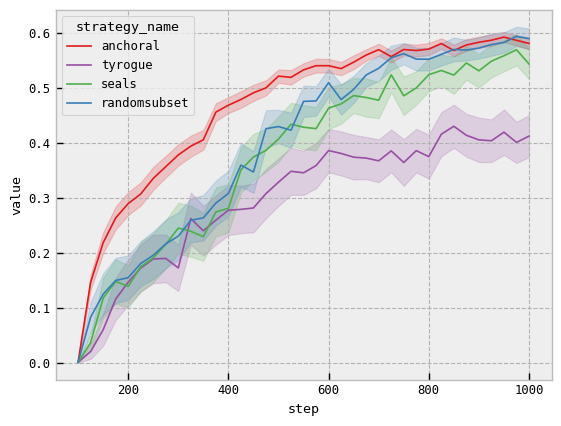

In [22]:
plot_data = df.loc[df["tag"].isin(["test/f1_class1_vs_budget"])]

hue_col = "strategy_name"
legend_order = sorted(plot_data[hue_col].unique().tolist())
palette = dict(zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order))))


sns.lineplot(
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue=hue_col,
    palette=palette,
)

In [ ]:
plot_data = df.loc[(df["tag"].isin(["test/f1_class1_vs_budget"])) & (df["strategy_name"] == "anchoral")]
 
g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, xlim),
    # ylim=ylim,
    sharey=False,
    col_order=col_order,
)
g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue=hue_col,
    palette=palette,
)
g.tight_layout()
g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)
g.add_legend(
    label_order=legend_order, bbox_to_anchor=(0.82, 0.25), title=hue_col
)

---
### Plots

In [ ]:
def plot(
    plot_data,
    hue_col,
    col_order=col_order,
    palette=None,
    legend_order=None,
    xlim=1_000,
) -> None:

    g = sns.FacetGrid(
        plot_data,
        col="dataset",
        col_wrap=3,
        sharex=True,
        legend_out=True,
        despine=True,
        xlim=(0, xlim),
        # ylim=ylim,
        sharey=False,
        col_order=col_order,
    )
    g.map_dataframe(
        sns.lineplot,
        data=plot_data,
        x="step",
        y="value",
        errorbar=("se", 1),
        hue=hue_col,
        palette=palette,
    )
    g.tight_layout()
    g.set_axis_labels("", "")
    g.set_titles(
        col_template="{col_name}",
    )
    g.add_legend(
        label_order=legend_order, bbox_to_anchor=(0.82, 0.25), title=hue_col
    )
    # plt.savefig(fname=f"p.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
    return g

In [ ]:
metric = "test/f1_class1_vs_budget"
hue_col = "strategy_name"

plot_data = df
legend_order = sorted(plot_data[hue_col].unique().tolist())
palette = dict(zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order))))

plot(plot_data, hue_col=hue_col, palette=palette, legend_order=legend_order)

In [ ]:
metric = "test/f1_class1_vs_budget"
hue_col = "subset_size"

plot_data = ddf.loc[
    (ddf["group"].isin(["seeds", hue_col])) & (ddf["tag"] == metric)
].assign(**{hue_col: lambda _df: _df[hue_col].astype(int).astype(str)})

legend_order = sorted(plot_data[hue_col].unique().tolist(), key=lambda ex: int(ex))
palette = dict(
    zip(legend_order, sns.color_palette("Set1", n_colors=len(legend_order)))
)

fig = plot(
    plot_data, hue_col=hue_col, palette=palette, legend_order=legend_order, xlim=800
)

In [ ]:
plot_data = (
    ddf.loc[(ddf["group"].isin(["seeds", hue_col])) & (ddf["tag"] == metric)]
    .assign(**{hue_col: lambda _df: _df[hue_col].astype(int).astype(str)})
    .filter(["dataset", "step", "value", hue_col])
    .groupby(["dataset", hue_col, "step"])
    .agg(["mean", "std"])
    .stack(0)
    .reset_index()
    .drop(columns="level_3")
)

In [ ]:
plot_data

In [ ]:
fig = px.line(
    plot_data,
    x="step",
    y="mean",
    color="subset_size",
    facet_col="dataset",
    facet_col_wrap=3,
)
fig.update_yaxes(matches=None)
fig.show()

In [ ]:
def f(s) -> str:
    return (
        r"\floatpm[2]{" + s.mean().astype(str) + r"}{" + s.std().astype(str) + r"}"
    )


def load_from_folder(path: Path, metrics: list[str]) -> pl.DataFrame:

    path = Path(path)
    list_df = []

    for p in tqdm(list(path.rglob("*tb_logs.parquet"))):
        strategy = p.parents[0].name.split("_")[0]
        dataset = p.parents[1].name

        meta = srsly.read_yaml(p.parent / "hparams.yaml")

        df = (
            pl.scan_parquet(p)
            # .filter(pl.col("tag").is_in(metrics))
            .with_columns(
                strategy=pl.lit(strategy),
                dataset=pl.lit(dataset),
                path=pl.lit(p.parent.name),
                data_seed=meta["data"]["seed"],
                model_seed=meta["model"]["seed"],
                seed=pl.lit(f'{meta["data"]["seed"]}-{meta["model"]["seed"]}'),
                group=p.parents[2].name,
                num_anchors=meta["strategy"].get("num_anchors", None),
                subset_size=meta["strategy"].get("subset_size", None),
                num_neighbours=meta["strategy"].get("num_neighbours", None),
                anchor_strategy=meta["strategy"].get("anchor_strategy", None),
                positive_budget=meta["active_data"].get("positive_budget", None),
                retriever=meta["index_metric"],
            )
        )

        list_df.append(df)

    return (
        pl.concat(list_df)
        # .groupby(["strategy", "dataset", "step"])
        # .agg(mean=pl.col("value").mean(), std=pl.col("value").std(), n=pl.count("value"))
        .collect(streaming=True)
    )

In [ ]:
df = load_from_folder("../outputs/multirun", None)

In [ ]:
pd.read_parquet(
    "../outputs/multirun/initial_set/agnews/random_2023-06-22T21-37-04_active_train_59/tb_logs.parquet"
)

In [ ]:
dd = df.collect(streaming=True)

In [ ]:
anchor_strategy_path = Path("../outputs/multirun/anchor_strategy/")
initial_set_path = Path("../outputs/multirun/initial_set/")
num_anchors_path = Path("../outputs/multirun/num_anchors/")
retriever_path = Path("../outputs/multirun/retriever/")
seeds_path = Path("../outputs/multirun/seeds/")
subset_size_path = Path("../outputs/multirun/subset_size/")

In [ ]:
metrics = [
    "test/f1_class1_vs_budget",
    "summary/count_class_1",
    "summary/ids_retrieved",
    "summary/unique_ids_retrieved",
    "summary/subset_size",
]

In [ ]:
anchor_strategy_df = load_from_folder(anchor_strategy_path, metrics)
initial_set_df = load_from_folder(initial_set_path, metrics)
num_anchors_df = load_from_folder(num_anchors_path, metrics)
retriever_df = load_from_folder(retriever_path, metrics)
seeds_df = load_from_folder(seeds_path, metrics)
subset_size_df = load_from_folder(subset_size_path, metrics)

In [ ]:
mapper = {
    "random": "Random",
    "randomsubset": "RandomSubset",
    "all": "AnchorAL",
    "all-anchorssubset-min": "SEALS",
}

anchor_strategy_df = anchor_strategy_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
initial_set_df = initial_set_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
num_anchors_df = num_anchors_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
retriever_df = retriever_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)
seeds_df = seeds_df.with_columns(strategy_name=pl.col("strategy").map_dict(mapper))
subset_size_df = subset_size_df.with_columns(
    strategy_name=pl.col("strategy").map_dict(mapper)
)

In [ ]:
col_order = ["amazon", "pubmed", "eurlex", "agnews", "wiki_toxic"]
strategy_order = sorted(seeds_df["strategy_name"].unique())

In [ ]:
mpl.rcParams["font.family"] = "monospace"  # "DejaVu Sans Mono"
plt.rcParams["font.size"] = 18
# plt.rcParams["axes.linewidth"] = 2
plt.style.use("bmh")
sns.set_context("paper")

# sorted(matplotlib.font_manager.get_font_names())

In [ ]:
palette = dict(
    zip(strategy_order, sns.color_palette("Set1", n_colors=len(strategy_order)))
)


def plot(
    plot_data: pd.DataFrame,
    palette=palette,
    xlim=(0, None),
    ylim=(-0.001, None),
    col_order=col_order,
    strategy_order=strategy_order,
    filename=None,
) -> None:
    g = sns.FacetGrid(
        plot_data,
        col="dataset",
        col_wrap=3,
        sharex=True,
        legend_out=True,
        despine=True,
        xlim=xlim,
        ylim=ylim,
        sharey=False,
        col_order=col_order,
    )

    g.tight_layout()

    g.map_dataframe(
        sns.lineplot,
        data=plot_data,
        x="step",
        y="value",
        errorbar=("se", 1),
        hue="strategy_name",
        palette=palette,
    )

    g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if xlim[1] == 2600 else 0.6)
    g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if xlim[1] == 2600 else 0.65)
    g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if xlim[1] == 2600 else 0.55)
    g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
    g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if xlim[1] == 2600 else 0.75)

    g.set_axis_labels("", "")
    g.set_titles(
        col_template="{col_name}",
    )
    g.add_legend(label_order=strategy_order, bbox_to_anchor=(0.82, 0.25))
    # g.despine()
    if filename:
        plt.savefig(
            fname=f"{filename}.png",
            dpi=1000,
            transparent=True,
            bbox_inches="tight",
            pad_inches=0,
        )
    plt.show()

---
### checks

In [ ]:
check_df = anchor_strategy_df

In [ ]:
check_df["strategy"].unique().to_list()

In [ ]:
check_df["dataset"].unique().to_list()
assert check_df["dataset"].nunique() == len(col_order)

In [ ]:
check_df.groupby(["dataset", "strategy"]).agg(pl.col("path").n_unique()).sort(
    ["strategy"]
).filter(pl.col("path") < 9)

In [ ]:
seeds_df.filter(
    (pl.col("dataset") == "amazon") & (pl.col("strategy") == "all-anchorssubset-min")
)["seed"].value_counts()

In [ ]:
seeds_df.filter(
    (pl.col("dataset") == "wiki_toxic")
    & (pl.col("strategy") == "all-anchorssubset-min")
).groupby(["seed", "path"]).agg(pl.col("value").mean()).sort(pl.col("seed"))

In [ ]:
done = set(
    seeds_df.filter(
        (pl.col("dataset") == "wiki_toxic")
        & (pl.col("strategy") == "all-anchorssubset-min")
    )["seed"].unique()
)
total = set(f"{i}-{j}" for i, j in product([42, 0, 1994], [42, 0, 1994]))
total.difference(done)

---
### Learning curves

In [ ]:
plot_data = seeds_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()

In [ ]:
plot(plot_data, palette, xlim=(0, 2600), filename="img_learning_curves_2600")

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "Strategy"])[["auc_1000", "auc"]]
    .agg(f)
    .to_latex()
)

In [ ]:
print(metrics[1])
plot_data = (
    seeds_df.filter(
        (pl.col("strategy_name").is_in(mapper.values()))
        & (pl.col("tag") == metrics[1])
    )
    .to_pandas()
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

In [ ]:
strategies = sorted(plot_data["strategy_name"].unique())
palette = dict(zip(strategies, sns.color_palette("Set1", n_colors=len(strategies))))
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    # ylim=(-.001,None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="strategy_name",
    palette=palette,
)

# g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(label_order=strategies, bbox_to_anchor=(0.82, 0.25))
# g.despine()
# plt.savefig(fname=f"learning_curves_{ymax}.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
def _f(_df):
    return (
        r"\floatpm[0]{"
        + _df["mean"].astype(str)
        + r"}{"
        + _df["std"].astype(str)
        + r"}"
    )


print(
    plot_data.query("step <= 1000")
    .assign(
        strategy_name=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
    )
    .groupby(["strategy_name", "dataset", "path"])["value"]
    .agg("sum")
    .reset_index()
    .groupby(["dataset", "strategy_name"])["value"]
    .agg(["mean", "std"])
    .assign(
        ratio=lambda _df: _df.groupby("dataset")["mean"].transform("max")
        / _df["mean"],
        latex=lambda _df: _df.apply(_f, axis=1),
    )
    .assign(latex_ratio=lambda _df: r"\float[2]{" + _df["ratio"].astype(str) + "}")
    .filter(["latex", "latex_ratio"])
    .to_latex()
    # .groupby("strategy_name")["ratio"].mean()
)

In [ ]:
a["ratio"] = a["mean"].max() / a["mean"]

In [ ]:
print(a.apply(f, axis=1).to_frame().join(a["ratio"].to_frame()).to_latex())

---

### Effect of the seed set

In [ ]:
plot_data = initial_set_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()

In [ ]:
plot(
    plot_data,
    palette,
    xlim=(0, 1000),
    filename="img_learning_curves_1000_initial_set",
)

In [ ]:
plot_data = pl.concat(
    [
        seeds_df.filter(
            (
                pl.col("strategy_name").is_in(
                    initial_set_df["strategy_name"].unique().to_list()
                )
            )
            & (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(n_positive=5),
        initial_set_df.filter(
            (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(n_positive=1),
    ]
).to_pandas()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data.loc[plot_data["strategy_name"] == "AnchorAL"],
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="n_positive",
    palette=dict(zip([5, 1], sns.color_palette("Set1", n_colors=2))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. minority in seed set")
plt.savefig(
    fname=f"img_num_minority_seed_set.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "Strategy", "n_positive"])[["auc_1000", "auc"]]
    .agg(f)
    .unstack(2)
    # .to_latex()
)

In [ ]:
# (
#    plot_data
#     .assign(
#         auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
#         auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
#     )
#     .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)
#     # .to_latex()
# )

In [ ]:
# plot_data = pl.concat(
#     [
#         seeds_df.filter(
#             (pl.col("strategy_name").is_in(initial_df["strategy_name"].unique().to_list()))
#             & (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(n_positive=5),
#         initial_df.filter(
#             (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1),
#     ]
# ).to_pandas().assign(step=lambda _df: (_df["step"] * 25) + 100)

In [ ]:
# ymax = 2600

# g = sns.FacetGrid(
#     plot_data,
#     col="dataset",
#     col_wrap=3,
#     sharex=True,
#     legend_out=True,
#     despine=True,
#     # xlim=(0, ymax),
#     # ylim=(-.001,None),
#     sharey=False,
#     col_order=col_order,
# )

# g.tight_layout()

# g.map_dataframe(
#     sns.lineplot,
#     data=plot_data,
#     x="step",
#     y="value",
#     errorbar=("se", 2),
#     hue="n_positive",
#     palette=dict(zip([5, 1], sns.color_palette("Set1", n_colors=2))),
# )

# # g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# # g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# # g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# # g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# # g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

# g.set_axis_labels("", "")
# g.set_titles(col_template="{col_name}",)

# g.add_legend(bbox_to_anchor=(.79, .25), title="num. minority in seed set")
# # plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
# plt.show()

---
### Effect of the Retriever

In [ ]:
plot_data = pl.concat(
    [
        seeds_df.filter(
            (
                pl.col("strategy_name").is_in(
                    retriever_df["strategy_name"].unique().to_list()
                )
            )
            & (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(retriever=pl.lit("MPNet")),
        retriever_df.filter(
            (pl.col("strategy_name").is_in(mapper.values()))
            & (pl.col("tag") == "test/f1_class1_vs_budget")
        ).with_columns(retriever=pl.lit("MiniLM")),
    ]
).to_pandas()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    # ax=ax,
    hue="retriever",
    palette=dict(zip(["MPNet", "MiniLM"], sns.color_palette("Set1", n_colors=2))),
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="encoder model")
plt.savefig(
    fname=f"img_retriever.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
def g(s) -> str:
    return (
        r"\floatpm[2]{"
        + s["mean"].astype(str)
        + r"}{"
        + np.abs(s["std"]).astype(str)
        + r"}"
    )


(
    plot_data.assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
        dataset=lambda _df: "\\" + _df["dataset"],
        strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
    )
    .groupby(["dataset", "strategy", "retriever"])[["auc", "auc_1000"]]
    .agg(["mean", "std"])
    .stack(0)
    .stack(0)
    .unstack(2)
    .assign(diff=lambda _df: _df["MPNet"] - _df["MiniLM"])
    .unstack(3)
    .stack(0)
    .apply(g, 1)
    .unstack(3)
    .droplevel(1)
    .filter(["MPNet", "MiniLM", "diff"])
    # .to_latex()
)

In [ ]:
# plot_data = pl.concat(
#     [
#         seeds_df.filter(
#             (pl.col("strategy_name").is_in(retriever_df["strategy_name"].unique().to_list()))
#             & (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(retriever=pl.lit("MPNet")),
#         retriever_df.filter(
#             (pl.col("strategy_name").is_in(mapper.values()))
#             & (pl.col("tag") == metrics[1])
#         ).with_columns(strategy_name=pl.col("strategy").map_dict(mapper), retriever=pl.lit("MiniLM")),
#     ]
# ).to_pandas().assign(step=lambda _df: (_df["step"] * 25) + 100)

In [ ]:
# ymax = 2600

# g = sns.FacetGrid(
#     plot_data,
#     col="dataset",
#     col_wrap=3,
#     sharex=True,
#     legend_out=True,
#     despine=True,
#     # xlim=(0, ymax),
#     # ylim=(-.001,None),
#     sharey=False,
#     col_order=col_order,
# )

# g.tight_layout()

# g.map_dataframe(
#     sns.lineplot,
#     data=plot_data,
#     x="step",
#     y="value",
#     errorbar=("se", 2),
#     hue="retriever",
#     palette=dict(zip(["MPNet", "MiniLM"], sns.color_palette("Set1", n_colors=2))),
# )

# # g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# # g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# # g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# # g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# # g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)

# g.set_axis_labels("", "")
# g.set_titles(col_template="{col_name}",)

# g.add_legend(bbox_to_anchor=(.79, .25), title="num. minority in seed set")
# # plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
# plt.show()

---

### Effect of the Anchor Strategy

In [ ]:
plot_data = pd.concat(
    [
        (
            seeds_df.filter(
                pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                & (pl.col("strategy_name").is_in(mapper.values()))
                & (pl.col("tag") == metrics[0])
            )
            .to_pandas()
            .rename(columns={"strategy_name": "anchor_strategy"})
        ),
        (
            anchor_strategy_df.filter(pl.col("tag") == metrics[0])
            .to_pandas()
            .assign(
                anchor_strategy=lambda _df: (
                    _df["path"]
                    .str.split("-", expand=True)[0]
                    .str.strip()
                    .map(
                        {
                            "kmeans": "K-Means (All Labelled)",
                            "random": "Random (All Labelled)",
                        }
                    )
                    .str.title()
                )
            )
        ),
    ]
).reset_index(drop=True)

In [ ]:
plot_data["anchor_strategy"].unique()

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    # palette=palette,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
    # hue_order=strategies,)
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    # ax=ax,
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
    # style="strategy_name",
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="anchor seletion strategy")
plt.savefig(
    fname=f"img_anchor_strategy.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
(
    plot_data.assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["dataset", "anchor_strategy"])[["auc", "auc_1000"]]
    .agg(f)
    # .to_latex()
)

In [ ]:
plot_data = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-1])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-1])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

In [ ]:
ymax = 2600

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    # xlim=(0, ymax),
    ylim=(5000, 10500),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)

# g.axes_dict["agnews"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.6)
# g.axes_dict["pubmed"].set_ylim(-.001, 0.7 if ymax == 2600 else 0.65)
# g.axes_dict["eurlex"].set_ylim(-.001, 0.6 if ymax == 2600 else 0.55)
# g.axes_dict["wiki_toxic"].set_ylim(-.001, 0.8)
# g.axes_dict["amazon"].set_ylim(-.001, 0.8 if ymax == 2600 else 0.75)
# g.set(yscale='log')
g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. minority in seed set")
# plt.savefig(fname=f"num_minority_seed_set.png", dpi=1000, transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
metrics

---
### Num anchors

In [ ]:
path = Path("../outputs/multirun/num_anchors/")
h = []
for p in path.rglob("hparams.yaml"):
    n = {
        "path": p.parent.name,
        "num_anchors": srsly.read_yaml(p)["strategy"]["num_anchors"],
    }
    h.append(n)
num = pd.DataFrame(h).fillna("all")

In [ ]:
a = seeds_df.filter(
    (
        pl.col("strategy_name").is_in(
            num_anchors_df["strategy_name"].unique().to_list()
        )
    )
    & (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).with_columns(num_anchors=50)

b = num_anchors_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()
c = pd.merge(b, num, on="path", how="inner")
assert len(c) == len(b)

In [ ]:
plot_data = pd.concat([a.to_pandas(), c]).reset_index()
plot_data["num_anchors"] = (
    plot_data["num_anchors"]
    .astype(str)
    .map({"50": "50", "all": "all labelled set", "5.0": "5 (default)"})
)

In [ ]:
plot_data["num_anchors"].unique()

In [ ]:
ymax = 1000
l = sorted(plot_data["num_anchors"].unique().tolist())

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="num_anchors",
    palette=dict(zip(l, sns.color_palette("Set1", n_colors=len(l)))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="num. anchors")
plt.savefig(
    fname=f"img_num_anchors.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        # auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "num_anchors"])[["auc_1000"]]
    .agg(f)
    .unstack(1)
    .to_latex()
)

---
### Subset Size

In [ ]:
path = Path("../outputs/multirun/subset_size/")
h = []
for p in path.rglob("hparams.yaml"):
    n = {
        "path": p.parent.name,
        "subset_size": srsly.read_yaml(p)["strategy"]["subset_size"],
    }
    h.append(n)
num = pd.DataFrame(h).fillna("all")

In [ ]:
a = seeds_df.filter(
    (
        pl.col("strategy_name").is_in(
            subset_size_df["strategy_name"].unique().to_list()
        )
    )
    & (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).with_columns(subset_size=10000)

b = subset_size_df.filter(
    (pl.col("strategy_name").is_in(mapper.values()))
    & (pl.col("tag") == "test/f1_class1_vs_budget")
).to_pandas()
c = pd.merge(b, num, on="path", how="inner")
assert len(c) == len(b)

In [ ]:
plot_data = pd.concat([a.to_pandas(), c]).reset_index()
plot_data.groupby(["dataset", "strategy"])["subset_size"].value_counts()

In [ ]:
ymax = 1000
l = sorted(plot_data["subset_size"].unique().tolist())

g = sns.FacetGrid(
    plot_data,
    col="dataset",
    col_wrap=3,
    sharex=True,
    legend_out=True,
    despine=True,
    xlim=(0, ymax),
    ylim=(-0.001, None),
    sharey=False,
    col_order=col_order,
)

g.tight_layout()

g.map_dataframe(
    sns.lineplot,
    data=plot_data,
    x="step",
    y="value",
    errorbar=("se", 1),
    hue="subset_size",
    palette=dict(zip(l, sns.color_palette("Set1", n_colors=len(l)))),
)

g.axes_dict["agnews"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.6)
g.axes_dict["pubmed"].set_ylim(-0.001, 0.7 if ymax == 2600 else 0.65)
g.axes_dict["eurlex"].set_ylim(-0.001, 0.6 if ymax == 2600 else 0.55)
g.axes_dict["wiki_toxic"].set_ylim(-0.001, 0.8)
g.axes_dict["amazon"].set_ylim(-0.001, 0.8 if ymax == 2600 else 0.75)

g.set_axis_labels("", "")
g.set_titles(
    col_template="{col_name}",
)

g.add_legend(bbox_to_anchor=(0.79, 0.25), title="subset size")
plt.savefig(
    fname=f"img_subset_size.png",
    dpi=1000,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

In [ ]:
print(
    plot_data.assign(
        Dataset=lambda _df: "\\" + _df["dataset"].str.replace("_", ""),
        Strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
        # auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["Dataset", "subset_size"])[["auc_1000"]]
    .agg(f)
    .unstack(1)
    .to_latex()
)

---
### AUC

In [ ]:
table_data = pl.concat(
    [
        seeds_df.filter(
            pl.col("strategy_name").is_in(
                initial_df["strategy_name"].unique().to_list()
            )
        ).with_columns(n_positive=5),
        initial_df.with_columns(
            strategy_name=pl.col("strategy").map_dict(mapper), n_positive=1
        ),
    ]
)

print(
    table_data.to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
    )
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]]
    .agg(f)
    .to_latex()
)

In [ ]:
def g(s) -> str:
    return (
        r"\floatpm[2]{"
        + s["mean"].astype(str)
        + r"}{"
        + np.abs(s["std"]).astype(str)
        + r"}"
    )


(
    table_data.to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000")
        .groupby(["path"])["value"]
        .transform(np.trapz),
        dataset=lambda _df: "\\" + _df["dataset"],
        strategy=lambda _df: "\\" + _df["strategy_name"].str.lower(),
    )
    .groupby(["dataset", "strategy", "n_positive"])[["auc", "auc_1000"]]
    .agg(["mean", "std"])
    .stack(0)
    .stack(0)
    .unstack(2)
    .assign(diff=lambda _df: _df[5] - _df[1])
    .unstack(3)
    .stack(0)
    .apply(g, 1)
    .unstack(3)
    # .to_latex()
)

In [ ]:
 table_data
   .to_pandas()
    .assign(
        auc=lambda _df: _df.groupby(["path"])["value"].transform(np.trapz),
        auc_1000=lambda _df: _df.query(f"step <= 1000").groupby(["path"])["value"].transform(np.trapz),
    .groupby(["dataset", "strategy_name", "n_positive"])[["auc", "auc_1000"]].agg(f)

In [ ]:
a = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-1])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-1])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

b = (
    pd.concat(
        [
            (
                seeds_df.filter(
                    pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                    & (pl.col("strategy_name").is_in(mapper.values()))
                    & (pl.col("tag") == metrics[-2])
                )
                .to_pandas()
                .rename(columns={"strategy_name": "anchor_strategy"})
            ),
            (
                anchor_strategy_df.filter(pl.col("tag") == metrics[-2])
                .to_pandas()
                .assign(
                    anchor_strategy=lambda _df: (
                        _df["path"]
                        .str.split("-", expand=True)[0]
                        .str.strip()
                        .map(
                            {
                                "kmeans": "K-Means (All Labelled)",
                                "random": "Random (All Labelled)",
                            }
                        )
                        .str.title()
                    )
                )
            ),
        ]
    )
    .reset_index(drop=True)
    .assign(step=lambda _df: (_df["step"] * 25) + 100)
)

c = pd.concat(
    [
        (
            seeds_df.filter(
                pl.col("strategy_name").is_in(["AnchorAL", "SEALS"])
                & (pl.col("strategy_name").is_in(mapper.values()))
                & (pl.col("tag") == metrics[0])
            )
            .to_pandas()
            .rename(columns={"strategy_name": "anchor_strategy"})
        ),
        (
            anchor_strategy_df.filter(pl.col("tag") == metrics[0])
            .to_pandas()
            .assign(
                anchor_strategy=lambda _df: (
                    _df["path"]
                    .str.split("-", expand=True)[0]
                    .str.strip()
                    .map(
                        {
                            "kmeans": "K-Means (All Labelled)",
                            "random": "Random (All Labelled)",
                        }
                    )
                    .str.title()
                )
            )
        ),
    ]
).reset_index(drop=True)

In [ ]:
sns.lineplot(
    data=a.loc[a["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-1])
plt.xlim((100, 400))
plt.show()
sns.lineplot(
    data=b.loc[b["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-2])
plt.xlim((100, 400))
plt.ylim((100, 150000))
plt.show()
sns.lineplot(
    data=c.loc[c["dataset"] == "amazon"],
    x="step",
    y="value",
    errorbar=("se", 2),
    hue="anchor_strategy",
    palette=dict(
        zip(
            ["AnchorAL", "SEALS", "K-Means (All Labelled)", "Random (All Labelled)"],
            sns.color_palette("Set1", n_colors=4),
        )
    ),
)
plt.title(metrics[-2])
plt.xlim((100, 400))
# plt.ylim((100, 150000))
plt.show()

In [ ]:
metrics

In [ ]:
# dataset = "amazon"

# fig, ax = plt.subplots()

# # fig.dpi = dpi

# sns.lineplot(
#     x="step",
#     y="value",
#     data=plot_data.query("dataset == 'amazon'"),
#     errorbar=("se", 2),
#     ax=ax,
#     hue="anchor_strategy",
#     # palette=palette,
# )

# ax.xaxis.set_minor_locator(ticker.MultipleLocator(100))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# # ax.set_xlim(90, 1000)
# # ax.set_ylim(0, 0.8)

# ax.set_xlabel("Budget")
# # ax.set_ylabel("F1 Minority Class")

# # fig.suptitle(dataset.title())
# # ax.set_title(dataset.title().replace("_", ""), fontsize=12)
# # ax.set_title(f"Average over 9 runs", fontsize=10)

# # ax.legend(fontsize=10, bbox_to_anchor=(1, 1))
# ax.legend(fontsize=10)

# sns.despine()
# plt.show()